In [3]:
import numpy as np
from PIL import Image
from numpy.fft import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import scipy
from scipy import stats
import glob

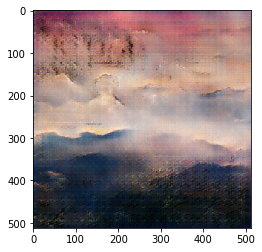

In [4]:
img_list = glob.glob(r'D:\corpor_download\grid_problem_samples\*')
# ------
i = 6
# ------
fileName = img_list[i]

img = Image.open(fileName)
img=img.convert('RGB')
img = np.array(img)/255.

r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]
plt.imshow(img)
# plt.show()
# plt.imshow(b)

In [5]:
h, w = r.shape
u = np.arange(- np.floor(w/2), np.floor((w+1)/2))
v = np.arange(- np.floor(h/2), np.floor((h+1)/2))
v.size, u.size

(512, 512)

In [6]:
r_target = fftshift(fft2(r))
g_target = fftshift(fft2(g))
b_target = fftshift(fft2(b))
r.shape

(512, 512)

In [7]:
uu,vv = np.meshgrid(u, v)
uu.shape, vv.shape

((512, 512), (512, 512))

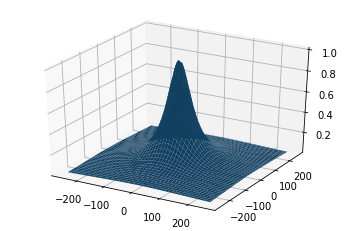

In [8]:
ax = plt.axes(projection='3d')
Filter = butter(vv,uu,1,50)
ax.plot_surface(vv, uu,Filter, 
                       linewidth=0, antialiased=True)

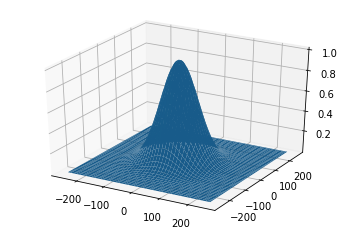

In [9]:
# ====================
sigma = 60
# ====================
Filter = gauss2d(uu,vv,sigma,0)
ax = plt.axes(projection='3d')
ax.plot_surface(uu,vv,Filter)

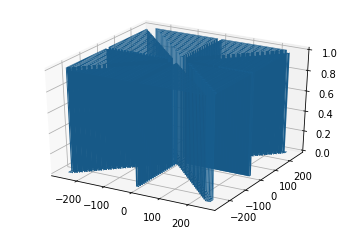

In [10]:
filter_one = np.zeros((512,512))
Np = 250
filter_one[-Np:,:Np] = 1
filter_one[:Np,:Np] = 1
filter_one[:Np,-Np:] = 1
filter_one[-Np:,-Np:] = 1
# ====================
delta = 20
# ====================
for i in range(512):
    for j in range(512):
        if i == j or abs(i-j) < delta or abs(i+j -512) < delta:
            filter_one[i,j] = 0
            
ax = plt.axes(projection='3d')
ax.plot_surface(uu,vv,filter_one)

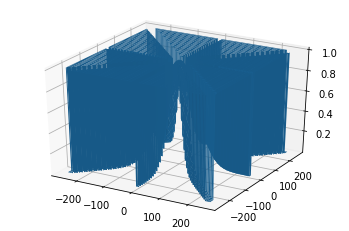

In [11]:

Filter = filter_one + Filter
Filter[Filter>1] = 1

ax = plt.axes(projection='3d')
ax.plot_surface(uu,vv,Filter)

In [12]:
r_target = fftshift(fft2(r))
g_target = fftshift(fft2(g))
b_target = fftshift(fft2(b))

r_target = Filter*r_target
g_target = Filter*g_target
b_target = Filter*b_target

r_target = ifftshift(r_target)
g_target = ifftshift(g_target)
b_target = ifftshift(b_target)
R = abs(ifft2(r_target))
G = abs(ifft2(g_target))
B = abs(ifft2(b_target))

R = R.reshape(w,h,1)
G = G.reshape(w,h,1)
B = B.reshape(w,h,1)
RGB = np.concatenate((R,G,B),2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


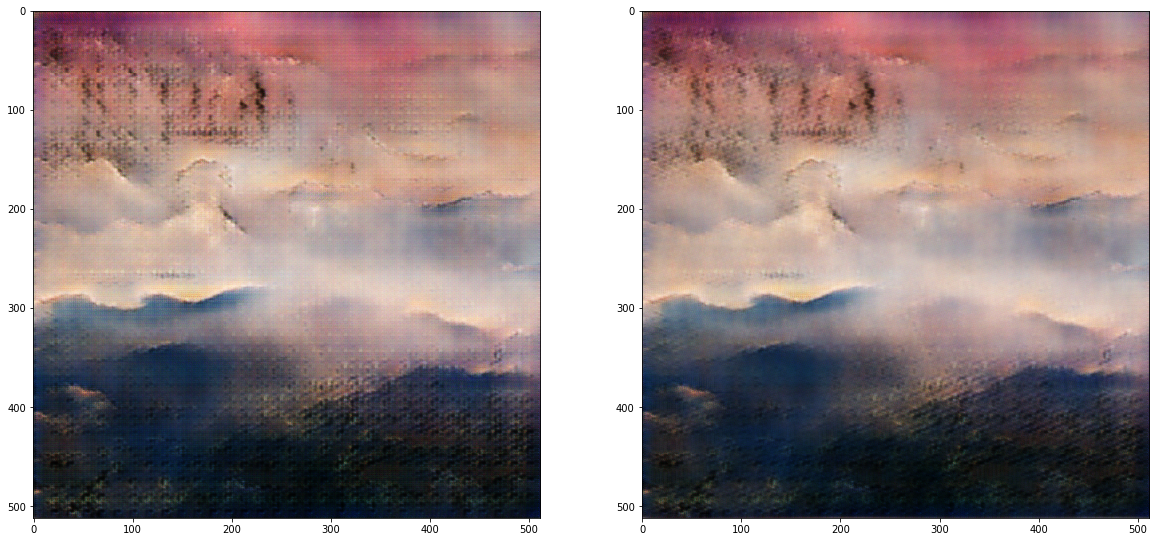

In [13]:
plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(RGB)
plt.show()

# 使用cv2的内置滤波器
OpenCV函数：`cv2.blur()`, `cv2.GaussianBlur()`, `cv2.medianBlur()`, `cv2.bilateralFilter()`

### 均值滤波  
$$
\text {kernel}=\frac{1}{9}\left[\begin{array}{ccc}{1} & {1} & {1} \\ {1} & {1} & {1} \\ {1} & {1} & {1}\end{array}\right]
$$

### 方框滤波
$$
k=a\left[\begin{array}{lll}{1} & {1} & {1} \\ {1} & {1} & {1} \\ {1} & {1} & {1}\end{array}\right]
$$
用`cv2.boxFilter()`函数实现，当可选参数normalize为True的时候，方框滤波就是均值滤波，上式中的a就等于1/9；normalize为False的时候，a=1，相当于求区域内的像素和。

### 高斯滤波
$$
k=\left[\begin{array}{ccc}{0.0625} & {0.125} & {0.0625} \\ {0.125} & {0.25} & {0.125} \\ {0.0625} & {0.125} & {0.0625}\end{array}\right]
$$
OpenCV中对应函数为`cv2.GaussianBlur(src,ksize,sigmaX)`：

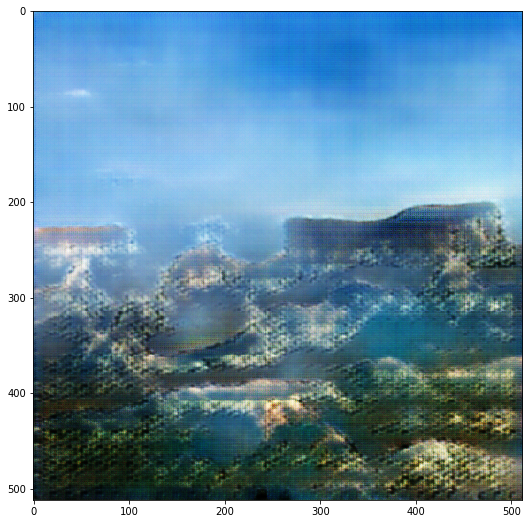

In [54]:
# input image
import cv2
img_list = glob.glob(r'D:\corpor_download\grid_problem_samples\*')
# ------
i = 2
# ------
fileName = img_list[i]
img = cv2.imread(fileName)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9,9))
plt.imshow(img)

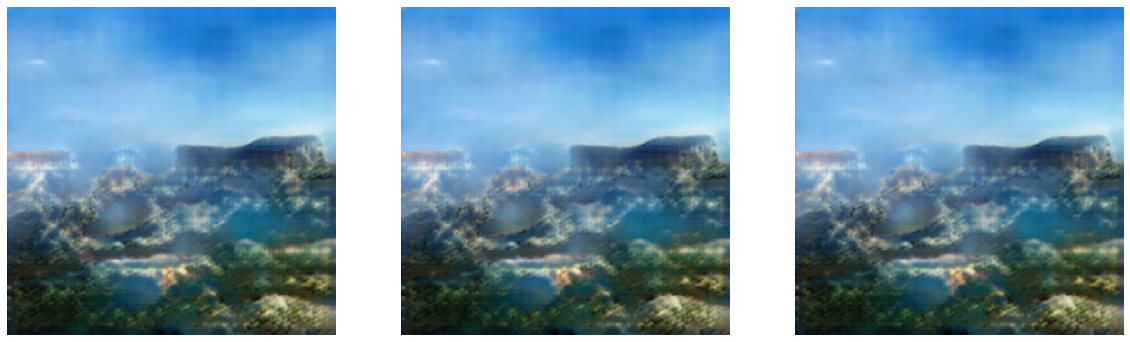

In [23]:
plt.figure(figsize=(20,35))
plt.subplot(1,3,1)
blur = cv2.blur(img, (5,5))  # 均值模糊
plt.axis('off')
plt.imshow(blur)

plt.subplot(1,3,2)
blur = cv2.boxFilter(img, -1, (5,5), normalize=True)
plt.imshow(blur)
plt.axis('off')

plt.subplot(1,3,3)
gaussian = cv2.GaussianBlur(img, (5, 5), 1)
plt.axis('off')
plt.imshow(blur)

### 中值滤波
中值又叫中位数，是所有数排序后取中间的值。中值滤波就是用区域内的中值来代替本像素值，所以那种孤立的斑点，如0或255很容易消除掉，适用于去除椒盐噪声和斑点噪声。中值是一种非线性操作，效率相比前面几种线性滤波要慢。  
比如斑点噪声图，用中值滤波显然更好：

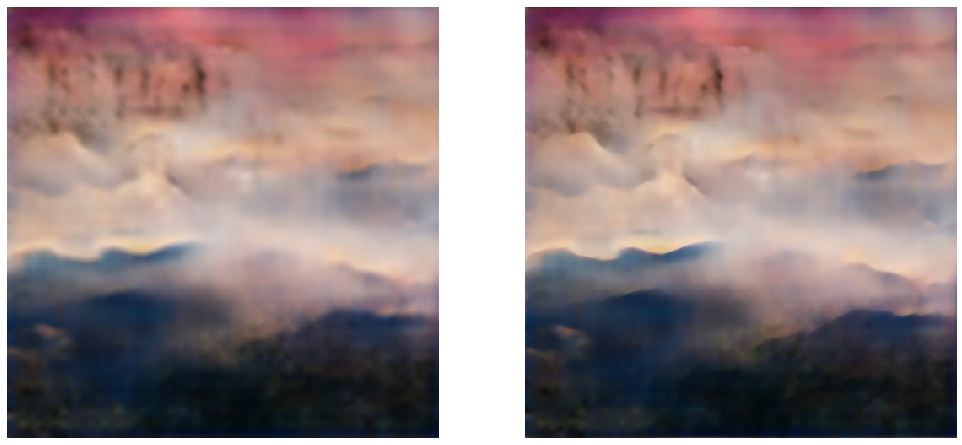

In [63]:
# 均值滤波vs中值滤波
#-------------------------
foo = RGB*255
img =  foo.astype('uint8') # 这里如果用我之前经过滤波后的图像
#-------------------------

blur = cv2.blur(img, (9,9))  # 均值滤波
median = cv2.medianBlur(img, 9)  # 中值滤波,@param ksize aperture linear size; it must be odd and greater than 1, for example: 3, 5, 7 ...

plt.figure(figsize=(17,35))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(blur)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(median)

### 双边滤波
模糊操作基本都会损失掉图像细节信息，尤其前面介绍的线性滤波器，图像的边缘信息很难保留下来。然而，边缘（edge）信息是图像中很重要的一个特征，所以这才有了双边滤波。用`cv2.bilateralFilter()`函数实现：

·   @param src Source 8-bit or floating-point, 1-channel or 3-channel image.  
.   @param dst Destination image of the same size and type as src .    
.   @param d Diameter of each pixel neighborhood that is used during filtering. If it is non-positive,
it is computed from sigmaSpace.  
.   @param sigmaColor Filter sigma in the color space. A larger value of the parameter means that
farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting
in larger areas of semi-equal color.  
.   @param sigmaSpace Filter sigma in the coordinate space. A larger value of the parameter means that
farther pixels will influence each other as long as their colors are close enough (see sigmaColor
). When d\>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is
proportional to sigmaSpace.  
.   @param borderType border mode used to extrapolate pixels outside of the image, see #BorderTypes

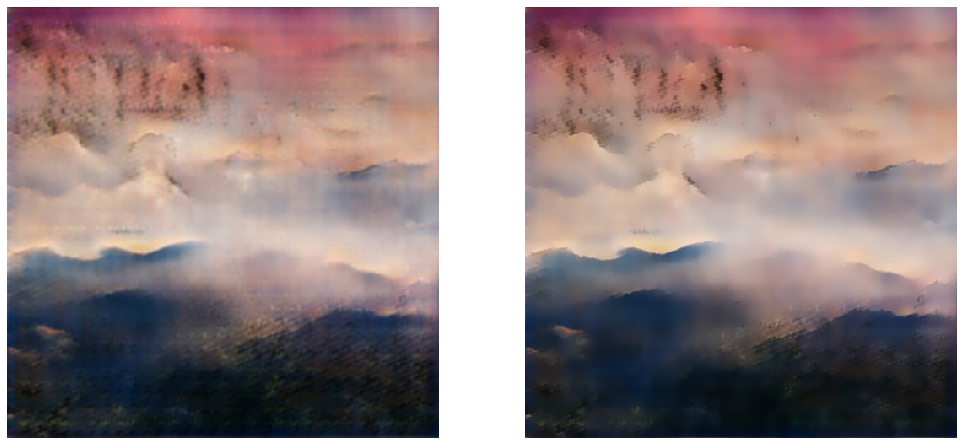

In [68]:
gau = cv2.GaussianBlur(img, (5, 5), 0)  # 高斯滤波
bilateral = cv2.bilateralFilter(img,15,35,35)  # 双边滤波 If they are small (\<. 10), the filter will not have much effect, whereas if they are large (\> 150), they will have a very strong effect, making the image look "cartoonish".

plt.figure(figsize=(17,35))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(gau)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(bilateral)

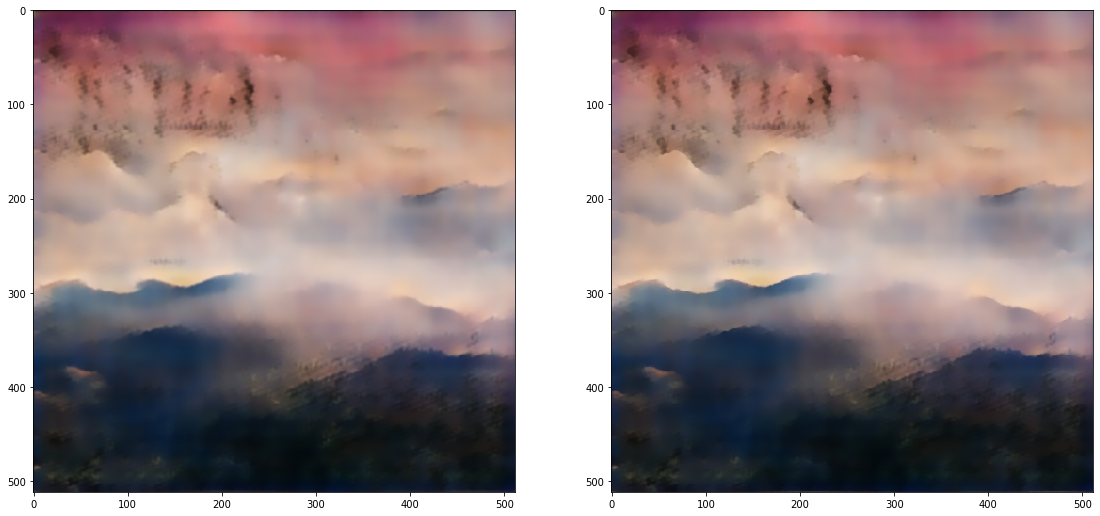

In [69]:
plt.figure(figsize=(19,29))

median = cv2.medianBlur(bilateral, 3) 
gaussian = cv2.GaussianBlur(bilateral, (3, 3), 1)
plt.subplot(1,2,1)
plt.imshow(gaussian)
plt.subplot(1,2,2)
plt.imshow(median)